# Example of Fitting RHESSI Spectra

This notebook provides a quick overlook of the fitting code in SunXspex and some real examples of fitting RHESSI spectra that can be compared to published works.

This Notebook has been run on my Macbook (processor: Intel i5-7360U @ 2.3 GHz).

**For a more explained demonstration of the general fitting process and capabilities see the NuSTAR fitting example.**

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) #
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
from sys import path as sys_path
sys_path.append('../sunxspex')
from sunxspex.sunxspex_fitting.fitter import SunXspex

In [3]:
from IPython.core.display import display, HTML
display(HTML('<style>.container{width:100% !important;}</style>'))

## Set up some plotting numbers

In [4]:
time_profile_size = (9,6)
spec_plot_size = (16,12)
tol = 1e-20
spec_font_size = 18
default_text = 10
xlims, ylims = [3,100], [5e-4,1e4]

# Let's fit a realistic example

Try fitting the spectra presented in [Fletcher *et al.* 2007](https://iopscience.iop.org/article/10.1086/510446). This M1.2 flare occurred on 2002 October 5.

First, load in the data...

In [5]:
rhess_spec = SunXspex(pha_file="../rhessiData/kc_flares/20021005_103800_spec.fits", srm_file="../rhessiData/kc_flares/20021005_103800_srm.fits")

To see what we have, we can plot the time profile. The whole file time is taken as the event time as default (indicated by purple shaded region).

We do this by accessing the RHESSI spectral loader in the `ress_spec.loaded_spec_data` dictionary. Since the RHESSI spectrum is the only one loaded it is under the `"spectrum1"` entry.

Default energy range plotted is all energies but the user can define an energy rangem or ranges. Ranges are inclusive at the bounds and here we see the 5$-$10 keV, 10$-$30 keV, and 25$-$50 keV ranges.

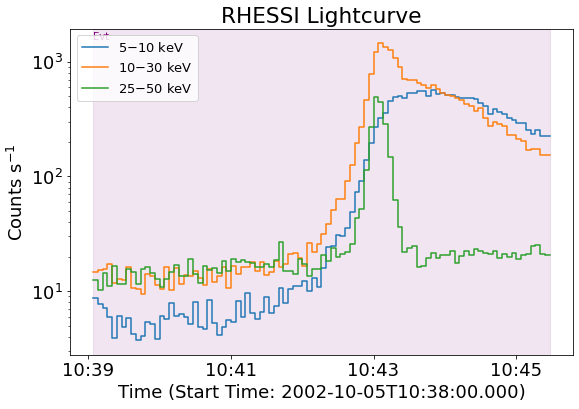

In [6]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=time_profile_size)

# the line that actually plots
rhess_spec.loaded_spec_data["spectrum1"].lightcurve(energy_ranges=[[5,10], [10,30], [25,50]])

plt.show()
plt.rcParams['font.size'] = default_text

Since the default event data is assumed to be the full time, we might want to change this. We also define a background time too and plot again.

No background has been set. Nothing has been changed.


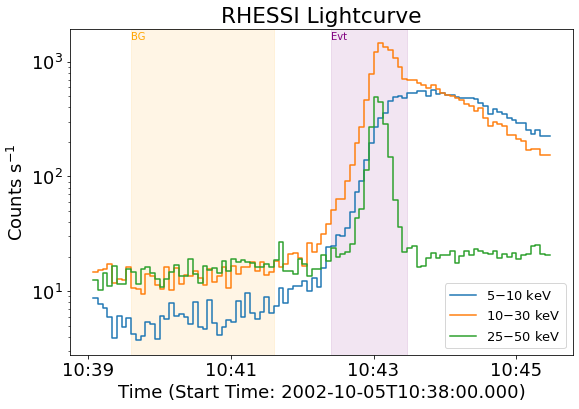

In [7]:
# background time. Both need to be set, if one is None (default) then no background will be calculated or will be removed
rhess_spec.loaded_spec_data["spectrum1"].start_background_time = "2002-10-05T10:38:32"
rhess_spec.loaded_spec_data["spectrum1"].end_background_time = "2002-10-05T10:40:32"

# event time
rhess_spec.loaded_spec_data["spectrum1"].start_event_time = "2002-10-05T10:41:20"
rhess_spec.loaded_spec_data["spectrum1"].end_event_time = "2002-10-05T10:42:24"

# plot again
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=time_profile_size)
rhess_spec.loaded_spec_data["spectrum1"].lightcurve(energy_ranges=[[5,10], [10,30], [25,50]])
plt.show()
plt.rcParams['font.size'] = default_text

We can also see the X-ray evolution via a spectrogram.

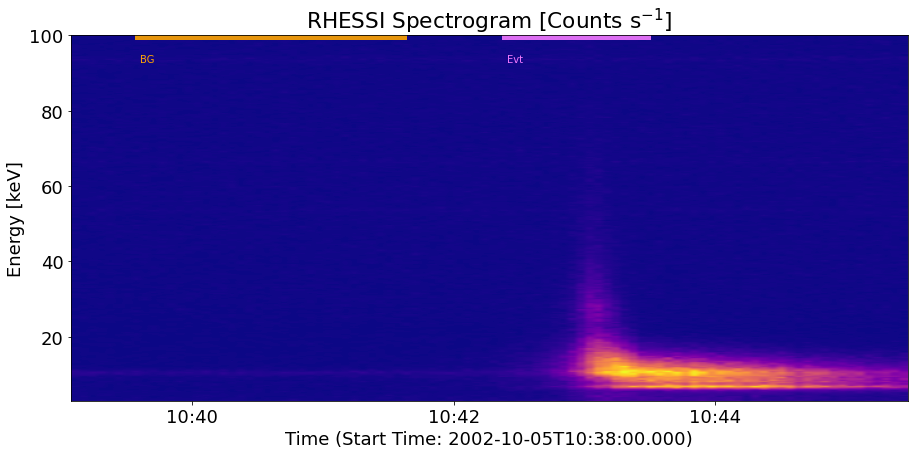

In [8]:
# plot spectrogram
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=(15,10))
rhess_spec.loaded_spec_data["spectrum1"].spectrogram()
plt.show()
plt.rcParams['font.size'] = default_text

An alternative to set the event and background times like above is by using the `select_time` method. E.g.,

```python
ress_spec.loaded_spec_data["spectrum1"].select_time(start="2002-10-05T10:38:32", end="2002-10-05T10:40:32", background=True)

ress_spec.loaded_spec_data["spectrum1"].select_time(start="2002-10-05T10:41:20", end="2002-10-05T10:42:24")
```
Both and end and a start time needs to be defined for the background, whereas the event time is assumed to commence/finish at the first/final data time if the start/end time is not given.

Now let's get going with a model and explicitly stating a fit statistic

In [8]:
rhess_spec.model = "(f_vth+thick_fn)"
rhess_spec.loglikelihood = "cstat"

See what parameters we have to play with:

In [9]:
rhess_spec.show_params

Param,Status,Value,Bounds,Error
,,,"(min, max)","(-, +)"
str22,str11,float64,object,object
T1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
EM1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
total_eflux1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
index1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
e_c1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
Fit Stat.,cstat ln(L),0.00e+00,--,--


Looking at the spectrum, define sensible numbers for starting values (maybe some trial and error here).

For this sepctrum, we will fit the thermal and non-thermal model over different energy ranges separately then both over the full range.

We fit the thermal model from 6$-$15 keV and fix the non-thermal model parameters.

In [10]:
# define energy fitting range
rhess_spec.energy_fitting_range = [6,15]

# sort model parameters
rhess_spec.params["T1_spectrum1"] = {"Value":50, "Bounds":(15, 99)}
rhess_spec.params["EM1_spectrum1"] = {"Value":2e1, "Bounds":(1e0, 1e4)}
rhess_spec.params["total_eflux1_spectrum1"] = {"Status":"fix", "Value":0.9, "Bounds":(1e-1, 1e1)}
rhess_spec.params["index1_spectrum1"] = {"Status":"fix", "Value":6, "Bounds":(3, 1e1)}
rhess_spec.params["e_c1_spectrum1"] = {"Status":"fix", "Value":2e1, "Bounds":(1e1, 1e2)}

Now perform the fit.

In [11]:
rhess_spec_fit = rhess_spec.fit(tol=tol)

Fix thermal parameters and free non-thermal parameters and fit over 15$-$45 keV.

In [12]:
# define energy fitting range
rhess_spec.energy_fitting_range = [15,45]

# sort model parameters
rhess_spec.params["T1_spectrum1"] = "fix"
rhess_spec.params["EM1_spectrum1"] = "fix"
rhess_spec.params["total_eflux1_spectrum1"] = "free"
rhess_spec.params["index1_spectrum1"] = "free"
rhess_spec.params["e_c1_spectrum1"] = "free"

# fit
rhess_spec_fit = rhess_spec.fit(tol=tol)

Free all parameters and fit over 6$-$45 keV.

In [13]:
# define energy fitting range
rhess_spec.energy_fitting_range = [6,45]

# sort model parameters
rhess_spec.params["T1_spectrum1"] = "free"
rhess_spec.params["EM1_spectrum1"] = "free"
rhess_spec.params["total_eflux1_spectrum1"] = "free"
rhess_spec.params["index1_spectrum1"] = "free"
rhess_spec.params["e_c1_spectrum1"] = "free"

# fit
rhess_spec_fit = rhess_spec.fit(tol=tol)

Let's plot the result. Since a background has been set it will be displayed in grey behind all other models and data.

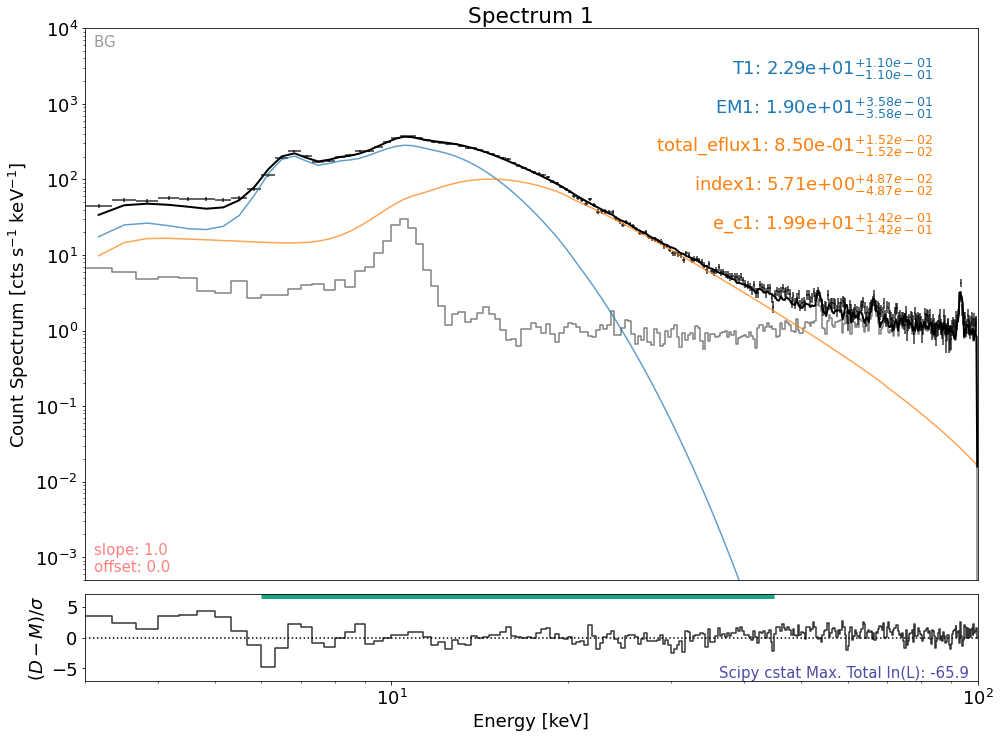

In [14]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)

# the line that actually plots
axes, res_axes = rhess_spec.plot()

# make plot nicer
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()
plt.rcParams['font.size'] = default_text

## How is the background included when fitting?

By default the (time scaled) background is added to the model then compared to the event data (i.e., fitting the event data with background+model). This is the recommended approach, especially since we're dealing with Poisson statistics.

However, this has been dificult in the past in software like OSPEX and so fitting usually been done by subtracting the background from the event time and fitting the model to the result (i.e., fitting the event-background with the model). To replicate this method we make use of the `data2data_minus_background` setter; we set this to True.

In [15]:
rhess_spec.loaded_spec_data["spectrum1"].data2data_minus_background = True

The data being fitted then becomes event-background and a dictionary key is set to make sure that the background is not included in the fitting process. Fitting continues as normal as though there is not background.

We then reset the parameter starting values, perform the fit, and plot again.

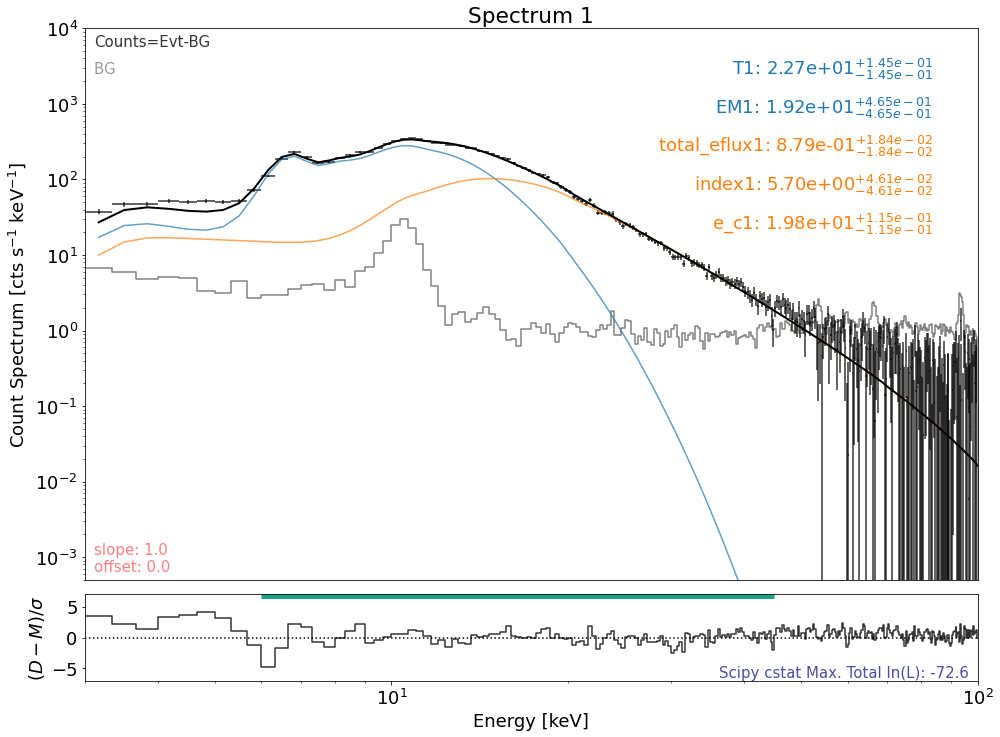

In [16]:
# define energy fitting range
rhess_spec.energy_fitting_range = [6,15]

# sort model parameters
rhess_spec.params["T1_spectrum1"] = {"Value":50, "Bounds":(15, 99)}#22
rhess_spec.params["EM1_spectrum1"] = {"Value":2e1, "Bounds":(1e0, 1e2)}#20
rhess_spec.params["total_eflux1_spectrum1"] = {"Status":"fix", "Value":0.9, "Bounds":(1e-1, 1e1)}
rhess_spec.params["index1_spectrum1"] = {"Status":"fix", "Value":6, "Bounds":(3, 1e1)}
rhess_spec.params["e_c1_spectrum1"] = {"Status":"fix", "Value":2e1, "Bounds":(1e1, 1e2)}

# fit
rhess_spec.fit(tol=tol)


# define energy fitting range
rhess_spec.energy_fitting_range = [15,45]

# sort model parameters
rhess_spec.params["T1_spectrum1"] = "fix"
rhess_spec.params["EM1_spectrum1"] = "fix"
rhess_spec.params["total_eflux1_spectrum1"] = "free"
rhess_spec.params["index1_spectrum1"] = "free"
rhess_spec.params["e_c1_spectrum1"] = "free"

# fit
rhess_spec.fit(tol=tol)


# define energy fitting range
rhess_spec.energy_fitting_range = [6,45]

# sort model parameters
rhess_spec.params["T1_spectrum1"] = "free"
rhess_spec.params["EM1_spectrum1"] = "free"
rhess_spec.params["total_eflux1_spectrum1"] = "free"
rhess_spec.params["index1_spectrum1"] = "free"
rhess_spec.params["e_c1_spectrum1"] = "free"

# fit
rhess_spec.fit(tol=tol)


# start plot
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)

# the line that actually plots
axes, res_axes = rhess_spec.plot()

# make plot nicer
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()
plt.rcParams['font.size'] = default_text

As we can see, there is a "Counts=Evt-BG" tag added in the top left corner of the plot along with the BG grey label to indicate that the counts being fitted are calculated from the background subtracted event data..

If the user wishes to undo this and wants to return to using the model+background fitting the event method then set `data2data_minus_background` back to False like so...

In [17]:
rhess_spec.loaded_spec_data["spectrum1"].data2data_minus_background = False

Any change to the background time and the `data2data_minus_background` setter will be set back to False. Therefore, if the user changes the background times at all and still wants the event-background method then the `data2data_minus_background` setter must be set to True again.

## Running an MCMC

Run the MCMC.

In [18]:
rhess_spec_mcmc = rhess_spec.run_mcmc()

100%|███████████████████████████████████████| 1200/1200 [06:18<00:00,  3.17it/s]


Look at the detailed MCMC results.

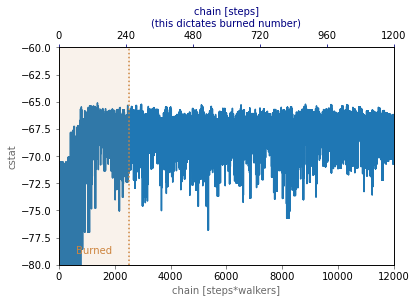

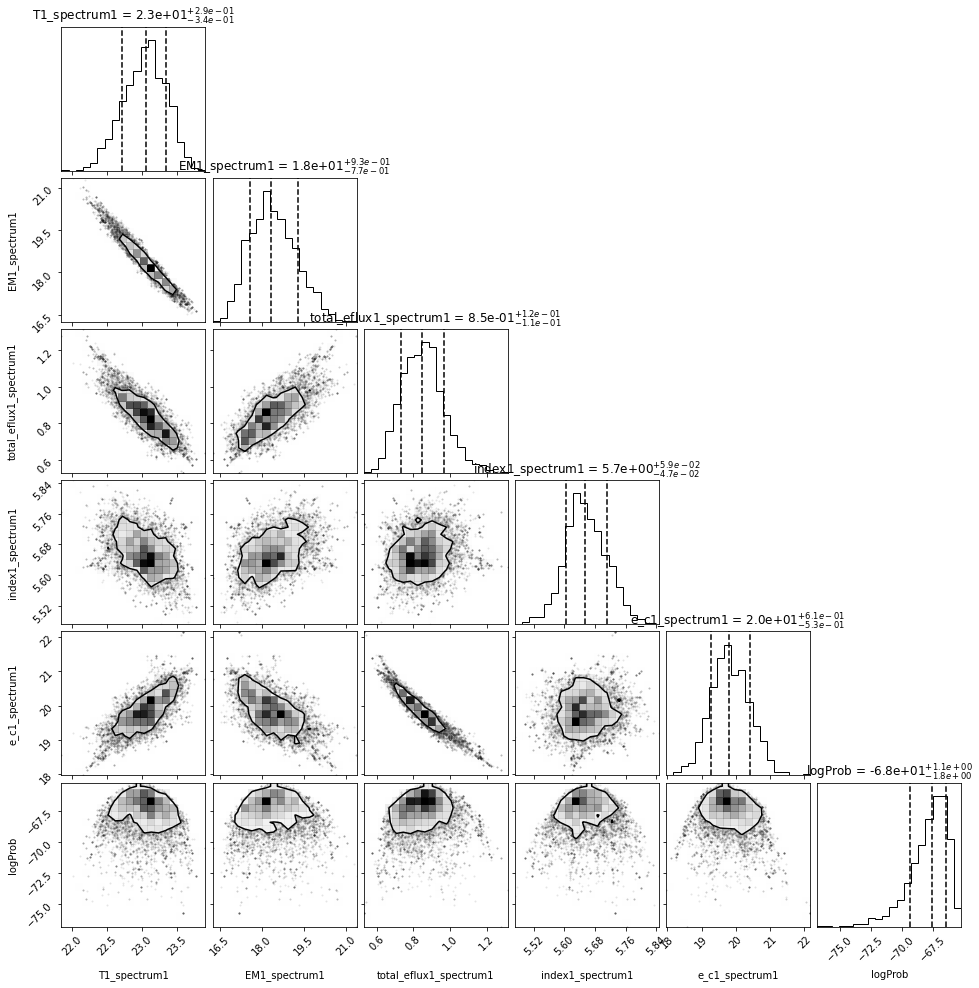

In [24]:
# burn the run in phase
rhess_spec.burn_mcmc = 250

# look if the log probability chain has settled and decide if the number of samples burned was appropriate
plt.figure()
rhess_spec.plot_log_prob_chain()
plt.ylim([-80,-60])
plt.show()

# produce a corner plot
corner_plot_ress_spec = rhess_spec.corner_mcmc()

Plot final spectral results.

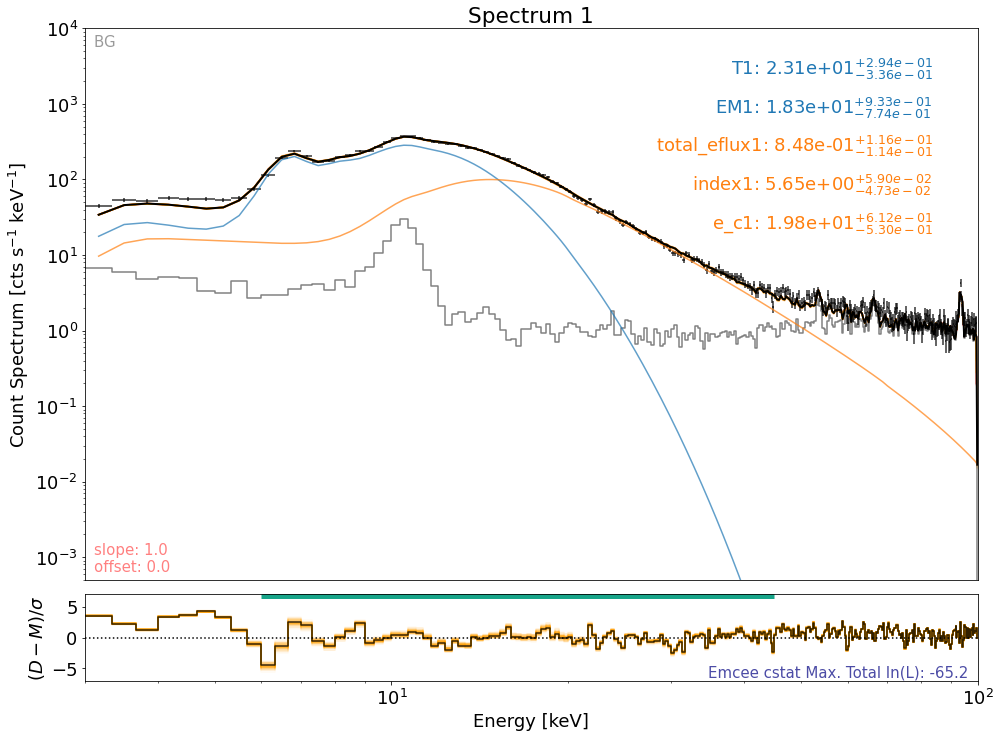

In [21]:
# start plot
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)

# the line that actually plots
axes, res_axes = rhess_spec.plot()

# make plot nicer
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()
plt.rcParams['font.size'] = default_text

## Save out session

In [22]:
save_filename = "../rhessiData/kc_flares/sunxspexRhessiSpectralFitting.pickle"
rhess_spec.save(save_filename)

## Loading session back in

The session can be loaded back in using the following code as an example,

```python
from sunxspex.sunxspex_fitting.fitter import load

rhessi_reloaded = load(save_filename)
```

## Comparisons

| Model Parameter                  | OSPEX (Flecther et al. 2007)*  | Recent OSPEX Fit (from Iain Hannah)| This Work (Minimize Soln, evt-bg)| This Work (Minimize Soln)       | This Work (MCMC)                        |
| :---                             |    :----:                      |     :----:                         |                         :----:   |                         :----:  |                                  ----:  |
| Temperature [MK]                 | 24.13                          | 22.45                              | 22.7$\pm$0.1                     | 22.9$\pm$0.1                    | 22.71$^{+0.29}_{-0.34}$                 |
| Emission Measure [cm$^{-3}$]     | 1.6$\times$10$^{47}$           | 2.0$\times$10$^{47}$               | 1.92$\pm$0.05$\times$10$^{47}$   | 1.90$\pm$0.04$\times$10$^{47}$  | 1.83$^{+0.09}_{-0.08}\times$10$^{47}$   |
| Electron Flux [e$^{-}$ s$^{-1}$] |   *                            | 9.8$\times$10$^{34}$               | 8.8$\pm$0.2$\times$10$^{34}$     | 8.5$\pm$0.2$\times$10$^{34}$    | 8.5$^{+1.1}_{-1.2}\times$10$^{34}$      |
| Index                            |   *                            | 5.77                               | 5.70$\pm$0.05                    | 5.71$\pm$0.05                   | 5.65$^{+0.06}_{-0.04}$                  |
| Low Energy Cut-off [keV]         |   *                            | 19.44                              | 19.8$\pm$0.1                     | 19.9$\pm$0.1                    | 19.8$^{+0.6}_{-0.5}$                    |

$^{*}$ Fletcher *et al.* 2007's spectrum is fit with a broken power-law model approximating the thick target model.

***

***